# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [3]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [6]:
your_name = "akshit" # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [7]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
27,55,female,35.06925,2,no,northwest,14108.927088
997,63,female,39.42950,0,no,southeast,15971.163775
162,54,male,42.37200,1,no,southwest,12018.134800
824,60,male,26.02240,0,no,northwest,14402.145520
392,48,male,33.64615,1,no,northeast,10308.669633


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [9]:
dataframe.shape

(1271, 7)

In [13]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 27 to 1205
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1271 non-null   int64  
 1   sex       1271 non-null   object 
 2   bmi       1271 non-null   float64
 3   children  1271 non-null   int64  
 4   smoker    1271 non-null   object 
 5   region    1271 non-null   object 
 6   charges   1271 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 79.4+ KB


In [14]:
num_rows = len(dataframe)
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [15]:
num_cols = len(dataframe.columns)
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [16]:
input_cols = dataframe.columns[:-1]
input_cols

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [17]:
categorical_cols = dataframe.select_dtypes(include=['object']).columns
categorical_cols

Index(['sex', 'smoker', 'region'], dtype='object')

**Q: What are the column titles of output/target variable(s)?**

In [18]:
output_cols = ['charges']
output_cols

['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [19]:
# Write your answer here
minimum = dataframe.charges.min()
maximum = dataframe.charges.max()
mean = dataframe.charges.mean()
print("minimum: {} ".format(minimum))
print("maximum: {} ".format(maximum))
print("mean: {} ".format(mean))

minimum: 1290.1549850000001 
maximum: 73335.99221150001 
mean: 15311.324601604136 


In [21]:
#second method
dataframe[output_cols].describe()

,charges
count,1271.000000
mean,15311.324602
std,13994.965032
min,1290.154985
25%,5465.206410
50%,10800.047900
75%,18921.296466
max,73335.992212


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f674828ef50>,
      dtype=object)

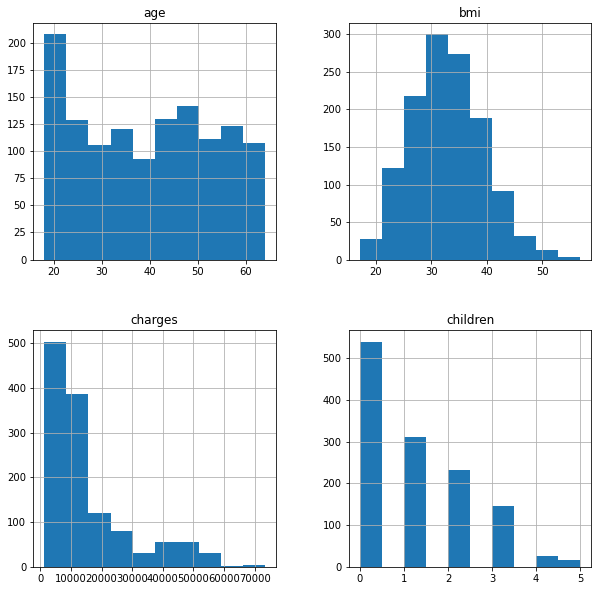

In [22]:
#Plotting graphs
dataframe.hist(figsize=(10,10), grid=True) 

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [23]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Updating notebook "imakshit/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/imakshit/02-insurance-linear-regression


'https://jovian.ml/imakshit/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [24]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [25]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[55.     ,  0.     , 35.06925,  2.     ,  0.     ,  1.     ],
        [63.     ,  0.     , 39.4295 ,  0.     ,  0.     ,  2.     ],
        [54.     ,  1.     , 42.372  ,  1.     ,  0.     ,  3.     ],
        ...,
        [58.     ,  1.     , 34.2507 ,  1.     ,  0.     ,  2.     ],
        [32.     ,  0.     , 47.3154 ,  0.     ,  0.     ,  2.     ],
        [35.     ,  1.     , 19.1102 ,  1.     ,  0.     ,  1.     ]]),
 array([[14108.9270875],
        [15971.163775 ],
        [12018.1348   ],
        ...,
        [13738.619785 ],
        [ 4593.30447  ],
        [ 5883.97546  ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [26]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)

In [27]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [28]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [29]:
val_percent = 0.12 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [30]:
batch_size = 64

In [31]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [32]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[29.0000,  1.0000, 39.9003,  2.0000,  0.0000,  2.0000],
        [19.0000,  1.0000, 21.8547,  0.0000,  0.0000,  1.0000],
        [45.0000,  1.0000, 24.4977,  2.0000,  1.0000,  1.0000],
        [62.0000,  1.0000, 34.3577,  0.0000,  0.0000,  0.0000],
        [21.0000,  1.0000, 25.4125,  2.0000,  0.0000,  1.0000],
        [44.0000,  0.0000, 39.0336,  0.0000,  0.0000,  0.0000],
        [60.0000,  1.0000, 26.0224,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000, 37.1290,  2.0000,  0.0000,  3.0000],
        [19.0000,  1.0000, 34.1544,  0.0000,  1.0000,  1.0000],
        [55.0000,  0.0000, 34.6627,  1.0000,  0.0000,  0.0000],
        [47.0000,  1.0000, 20.5333,  1.0000,  0.0000,  0.0000],
        [58.0000,  0.0000, 35.7808,  0.0000,  0.0000,  1.0000],
        [18.0000,  1.0000, 22.9729,  0.0000,  0.0000,  0.0000],
        [20.0000,  0.0000, 35.6310,  0.0000,  0.0000,  3.0000],
        [41.0000,  0.0000, 34.8820,  3.0000,  0.0000,  3.0000],
        [26.0000,  1.0000, 33.23

Let's save our work by committing to Jovian.

In [33]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "imakshit/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/imakshit/02-insurance-linear-regression


'https://jovian.ml/imakshit/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [34]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [38]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                       # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.smooth_l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.smooth_l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [39]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [40]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1534,  0.1815,  0.3413, -0.0936, -0.1887,  0.1762]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2136], requires_grad=True)]

One final commit before we train the model.

In [41]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "imakshit/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/imakshit/02-insurance-linear-regression


'https://jovian.ml/imakshit/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [42]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [43]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 15767.6396484375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [44]:
epochs = 10000
lr = 1e-5
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 15757.9053
Epoch [40], val_loss: 15748.1748
Epoch [60], val_loss: 15738.4385
Epoch [80], val_loss: 15728.7070
Epoch [100], val_loss: 15718.9756
Epoch [120], val_loss: 15709.2412
Epoch [140], val_loss: 15699.5029
Epoch [160], val_loss: 15689.7627
Epoch [180], val_loss: 15680.0273
Epoch [200], val_loss: 15670.2920
Epoch [220], val_loss: 15660.5518
Epoch [240], val_loss: 15650.8164
Epoch [260], val_loss: 15641.0791
Epoch [280], val_loss: 15631.3438
Epoch [300], val_loss: 15621.6123
Epoch [320], val_loss: 15611.8799
Epoch [340], val_loss: 15602.1475
Epoch [360], val_loss: 15592.4180
Epoch [380], val_loss: 15582.6846
Epoch [400], val_loss: 15572.9521
Epoch [420], val_loss: 15563.2148
Epoch [440], val_loss: 15553.4795
Epoch [460], val_loss: 15543.7432
Epoch [480], val_loss: 15534.0117
Epoch [500], val_loss: 15524.2725
Epoch [520], val_loss: 15514.5469
Epoch [540], val_loss: 15504.8164
Epoch [560], val_loss: 15495.0820
Epoch [580], val_loss: 15485.3477
Epoch [600], val_l

Epoch [4740], val_loss: 13473.6338
Epoch [4760], val_loss: 13464.2432
Epoch [4780], val_loss: 13454.8643
Epoch [4800], val_loss: 13445.4922
Epoch [4820], val_loss: 13436.1104
Epoch [4840], val_loss: 13426.7305
Epoch [4860], val_loss: 13417.3506
Epoch [4880], val_loss: 13407.9736
Epoch [4900], val_loss: 13398.6064
Epoch [4920], val_loss: 13389.2744
Epoch [4940], val_loss: 13379.9834
Epoch [4960], val_loss: 13370.7139
Epoch [4980], val_loss: 13361.4463
Epoch [5000], val_loss: 13352.1787
Epoch [5020], val_loss: 13342.9268
Epoch [5040], val_loss: 13333.6787
Epoch [5060], val_loss: 13324.4150
Epoch [5080], val_loss: 13315.1650
Epoch [5100], val_loss: 13305.9502
Epoch [5120], val_loss: 13296.7295
Epoch [5140], val_loss: 13287.5107
Epoch [5160], val_loss: 13278.2920
Epoch [5180], val_loss: 13269.0811
Epoch [5200], val_loss: 13259.8799
Epoch [5220], val_loss: 13250.6875
Epoch [5240], val_loss: 13241.5068
Epoch [5260], val_loss: 13232.3291
Epoch [5280], val_loss: 13223.1455
Epoch [5300], val_lo

Epoch [9440], val_loss: 11521.2031
Epoch [9460], val_loss: 11514.2188
Epoch [9480], val_loss: 11507.2471
Epoch [9500], val_loss: 11500.2881
Epoch [9520], val_loss: 11493.3252
Epoch [9540], val_loss: 11486.3594
Epoch [9560], val_loss: 11479.4375
Epoch [9580], val_loss: 11472.4971
Epoch [9600], val_loss: 11465.6221
Epoch [9620], val_loss: 11458.7930
Epoch [9640], val_loss: 11451.9688
Epoch [9660], val_loss: 11445.1846
Epoch [9680], val_loss: 11438.4014
Epoch [9700], val_loss: 11431.6279
Epoch [9720], val_loss: 11424.8701
Epoch [9740], val_loss: 11418.1123
Epoch [9760], val_loss: 11411.3486
Epoch [9780], val_loss: 11404.5947
Epoch [9800], val_loss: 11397.8203
Epoch [9820], val_loss: 11391.0479
Epoch [9840], val_loss: 11384.2881
Epoch [9860], val_loss: 11377.5361
Epoch [9880], val_loss: 11370.7783
Epoch [9900], val_loss: 11364.0127
Epoch [9920], val_loss: 11357.2617
Epoch [9940], val_loss: 11350.5010
Epoch [9960], val_loss: 11343.7344
Epoch [9980], val_loss: 11336.9834
Epoch [10000], val_l

In [46]:
def graph_loss(history):
    loss = []
    for x in history:
        loss.append(x['val_loss'])
    plt.plot(loss)

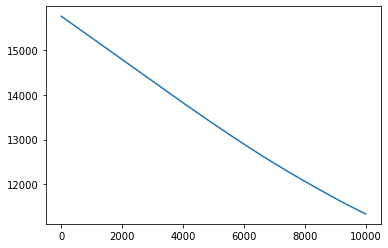

In [47]:
graph_loss(history1)

In [52]:
epochs = 7000
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7544.1470
Epoch [40], val_loss: 7544.1411
Epoch [60], val_loss: 7544.1118
Epoch [80], val_loss: 7544.1040
Epoch [100], val_loss: 7543.9941
Epoch [120], val_loss: 7544.0156
Epoch [140], val_loss: 7544.0293
Epoch [160], val_loss: 7544.0356
Epoch [180], val_loss: 7543.9453
Epoch [200], val_loss: 7543.9868
Epoch [220], val_loss: 7543.9629
Epoch [240], val_loss: 7543.9575
Epoch [260], val_loss: 7543.8892
Epoch [280], val_loss: 7543.7876
Epoch [300], val_loss: 7543.8003
Epoch [320], val_loss: 7543.7007
Epoch [340], val_loss: 7543.6030
Epoch [360], val_loss: 7543.5234
Epoch [380], val_loss: 7543.5664
Epoch [400], val_loss: 7543.6108
Epoch [420], val_loss: 7543.5278
Epoch [440], val_loss: 7543.5063
Epoch [460], val_loss: 7543.5015
Epoch [480], val_loss: 7543.5210
Epoch [500], val_loss: 7543.3516
Epoch [520], val_loss: 7543.3521
Epoch [540], val_loss: 7543.3120
Epoch [560], val_loss: 7543.3301
Epoch [580], val_loss: 7543.3398
Epoch [600], val_loss: 7543.3398
Epoch [620], v

Epoch [4880], val_loss: 7530.6001
Epoch [4900], val_loss: 7530.5933
Epoch [4920], val_loss: 7530.4995
Epoch [4940], val_loss: 7530.3418
Epoch [4960], val_loss: 7530.3750
Epoch [4980], val_loss: 7530.3535
Epoch [5000], val_loss: 7530.2090
Epoch [5020], val_loss: 7530.1147
Epoch [5040], val_loss: 7530.1753
Epoch [5060], val_loss: 7530.0552
Epoch [5080], val_loss: 7529.9849
Epoch [5100], val_loss: 7529.9575
Epoch [5120], val_loss: 7529.8770
Epoch [5140], val_loss: 7529.8120
Epoch [5160], val_loss: 7529.7642
Epoch [5180], val_loss: 7529.6792
Epoch [5200], val_loss: 7529.7437
Epoch [5220], val_loss: 7529.5952
Epoch [5240], val_loss: 7529.5435
Epoch [5260], val_loss: 7529.5098
Epoch [5280], val_loss: 7529.4419
Epoch [5300], val_loss: 7529.3364
Epoch [5320], val_loss: 7529.2383
Epoch [5340], val_loss: 7529.3130
Epoch [5360], val_loss: 7529.3281
Epoch [5380], val_loss: 7529.1138
Epoch [5400], val_loss: 7529.0659
Epoch [5420], val_loss: 7529.0444
Epoch [5440], val_loss: 7528.9370
Epoch [5460], 

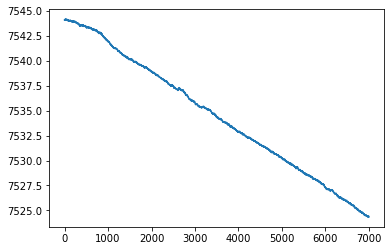

In [53]:
graph_loss(history2)

In [56]:
epochs = 2000
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7522.2500
Epoch [40], val_loss: 7522.2437
Epoch [60], val_loss: 7522.2344
Epoch [80], val_loss: 7522.2329
Epoch [100], val_loss: 7522.2310
Epoch [120], val_loss: 7522.2241
Epoch [140], val_loss: 7522.2251
Epoch [160], val_loss: 7522.2109
Epoch [180], val_loss: 7522.2085
Epoch [200], val_loss: 7522.2129
Epoch [220], val_loss: 7522.2095
Epoch [240], val_loss: 7522.1890
Epoch [260], val_loss: 7522.1875
Epoch [280], val_loss: 7522.1714
Epoch [300], val_loss: 7522.1655
Epoch [320], val_loss: 7522.1646
Epoch [340], val_loss: 7522.1567
Epoch [360], val_loss: 7522.1562
Epoch [380], val_loss: 7522.1470
Epoch [400], val_loss: 7522.1470
Epoch [420], val_loss: 7522.1309
Epoch [440], val_loss: 7522.1255
Epoch [460], val_loss: 7522.1235
Epoch [480], val_loss: 7522.1157
Epoch [500], val_loss: 7522.1133
Epoch [520], val_loss: 7522.1055
Epoch [540], val_loss: 7522.1050
Epoch [560], val_loss: 7522.0874
Epoch [580], val_loss: 7522.0894
Epoch [600], val_loss: 7522.0786
Epoch [620], v

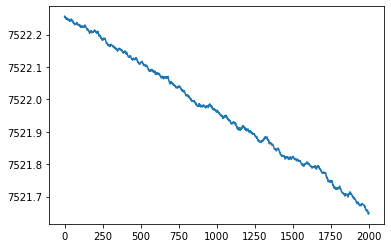

In [57]:
graph_loss(history3)

In [58]:
epochs = 1000
lr = 1e-2
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7521.2012
Epoch [40], val_loss: 7520.8765
Epoch [60], val_loss: 7520.3438
Epoch [80], val_loss: 7519.4419
Epoch [100], val_loss: 7519.9819
Epoch [120], val_loss: 7518.9360
Epoch [140], val_loss: 7518.0239
Epoch [160], val_loss: 7518.0786
Epoch [180], val_loss: 7516.5723
Epoch [200], val_loss: 7515.6401
Epoch [220], val_loss: 7515.3477
Epoch [240], val_loss: 7514.4922
Epoch [260], val_loss: 7514.3218
Epoch [280], val_loss: 7513.7456
Epoch [300], val_loss: 7513.1304
Epoch [320], val_loss: 7513.2539
Epoch [340], val_loss: 7512.7285
Epoch [360], val_loss: 7512.4023
Epoch [380], val_loss: 7511.9219
Epoch [400], val_loss: 7511.3911
Epoch [420], val_loss: 7511.1406
Epoch [440], val_loss: 7510.7593
Epoch [460], val_loss: 7509.7310
Epoch [480], val_loss: 7508.9106
Epoch [500], val_loss: 7508.6372
Epoch [520], val_loss: 7508.4771
Epoch [540], val_loss: 7508.1133
Epoch [560], val_loss: 7508.1001
Epoch [580], val_loss: 7507.2134
Epoch [600], val_loss: 7506.5918
Epoch [620], v

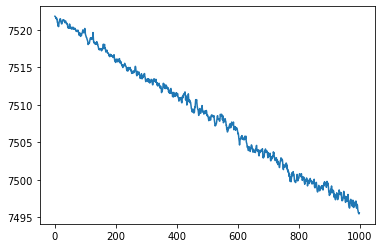

In [59]:
graph_loss(history4)

In [67]:
epochs = 10000
lr = 1e-2
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6930.3501
Epoch [40], val_loss: 6929.9624
Epoch [60], val_loss: 6929.9478
Epoch [80], val_loss: 6929.5918
Epoch [100], val_loss: 6929.4097
Epoch [120], val_loss: 6929.2778
Epoch [140], val_loss: 6929.2310
Epoch [160], val_loss: 6929.0742
Epoch [180], val_loss: 6929.0015
Epoch [200], val_loss: 6928.9058
Epoch [220], val_loss: 6928.6948
Epoch [240], val_loss: 6928.3540
Epoch [260], val_loss: 6928.3892
Epoch [280], val_loss: 6928.0845
Epoch [300], val_loss: 6927.8120
Epoch [320], val_loss: 6928.0059
Epoch [340], val_loss: 6927.9238
Epoch [360], val_loss: 6927.3101
Epoch [380], val_loss: 6927.0708
Epoch [400], val_loss: 6927.5054
Epoch [420], val_loss: 6926.8164
Epoch [440], val_loss: 6926.7847
Epoch [460], val_loss: 6926.4194
Epoch [480], val_loss: 6926.8101
Epoch [500], val_loss: 6926.1880
Epoch [520], val_loss: 6926.1245
Epoch [540], val_loss: 6925.9219
Epoch [560], val_loss: 6925.6699
Epoch [580], val_loss: 6925.8188
Epoch [600], val_loss: 6925.5859
Epoch [620], v

Epoch [4880], val_loss: 6889.4087
Epoch [4900], val_loss: 6889.6450
Epoch [4920], val_loss: 6889.2661
Epoch [4940], val_loss: 6889.0356
Epoch [4960], val_loss: 6888.8945
Epoch [4980], val_loss: 6888.9878
Epoch [5000], val_loss: 6888.8926
Epoch [5020], val_loss: 6888.5425
Epoch [5040], val_loss: 6888.0171
Epoch [5060], val_loss: 6888.0586
Epoch [5080], val_loss: 6888.0718
Epoch [5100], val_loss: 6887.8569
Epoch [5120], val_loss: 6887.9272
Epoch [5140], val_loss: 6887.5659
Epoch [5160], val_loss: 6887.2754
Epoch [5180], val_loss: 6887.4038
Epoch [5200], val_loss: 6887.0156
Epoch [5220], val_loss: 6886.8477
Epoch [5240], val_loss: 6886.7798
Epoch [5260], val_loss: 6886.4272
Epoch [5280], val_loss: 6886.4565
Epoch [5300], val_loss: 6885.9497
Epoch [5320], val_loss: 6885.7827
Epoch [5340], val_loss: 6885.9321
Epoch [5360], val_loss: 6885.8965
Epoch [5380], val_loss: 6885.6074
Epoch [5400], val_loss: 6885.1641
Epoch [5420], val_loss: 6885.2993
Epoch [5440], val_loss: 6884.8691
Epoch [5460], 

Epoch [9700], val_loss: 6849.3169
Epoch [9720], val_loss: 6849.0767
Epoch [9740], val_loss: 6848.9458
Epoch [9760], val_loss: 6848.7720
Epoch [9780], val_loss: 6848.7261
Epoch [9800], val_loss: 6848.6211
Epoch [9820], val_loss: 6848.3140
Epoch [9840], val_loss: 6848.1030
Epoch [9860], val_loss: 6847.6187
Epoch [9880], val_loss: 6847.5591
Epoch [9900], val_loss: 6847.5371
Epoch [9920], val_loss: 6847.4546
Epoch [9940], val_loss: 6847.3589
Epoch [9960], val_loss: 6847.0747
Epoch [9980], val_loss: 6846.8257
Epoch [10000], val_loss: 6846.8208


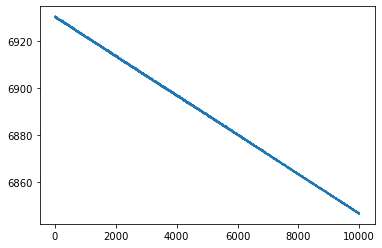

In [68]:
graph_loss(history5)

In [69]:
val_loss = history5[-1]
val_loss

{'val_loss': 6846.82080078125}

Let's log the final validation loss to Jovian and commit the notebook

In [70]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [71]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "imakshit/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/imakshit/02-insurance-linear-regression


'https://jovian.ml/imakshit/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [72]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [73]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([34.0000,  0.0000, 31.3082,  3.0000,  0.0000,  2.0000])
Target: tensor([7111.9443])
Prediction: tensor([7920.9741])


In [74]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([29.0000,  0.0000, 41.5481,  3.0000,  0.0000,  2.0000])
Target: tensor([5908.9951])
Prediction: tensor([5862.7451])


In [75]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([42.0000,  0.0000, 35.1709,  0.0000,  0.0000,  0.0000])
Target: tensor([8107.5244])
Prediction: tensor([9483.9277])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "imakshit/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/imakshit/02-insurance-linear-regression


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
